In [3]:
import torch
import sklearn
import sys
from tqdm import tqdm_notebook as tqdm
import random
import numpy as np
from torch.utils.data import Dataset, Subset
from torch.utils.data import TensorDataset, DataLoader
import torch.backends.cudnn as cudnn
from torch import nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from tqdm import tqdm_notebook
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [17]:
def example_dl(sample_num, transform=None):
    w = [2,-3.4]
    b = 4.2
    y = []

    x = np.random.normal(0,1,(sample_num,2))

    y.append(x @ w + b + np.random.normal(0,0.01,sample_num))
    
    x = torch.tensor(x.astype(np.float32))
    y = torch.tensor(np.array(y, dtype='float32'))

    dataset = torch.utils.data.TensorDataset(x.reshape(-1,2).unsqueeze(0),y.reshape(-1,1).unsqueeze(0))

    return dataset

In [14]:
# make dataloader
def create_dataloader(dataset_name, transform):
    if dataset_name == 'MNIST':
        train_dataset = datasets.FashionMNIST(root='../datasets', train=True, download=True, transform=transform)
        train_dl = DataLoader(train_dataset,   batch_size=TRAIN_BATCH_SIZE, shuffle=True)

        test_dataset = datasets.FashionMNIST(root='../datasets', train=False, download=True, transform=transform)
        test_dl = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
    
    if dataset_name == 'example':
        train_dataset = example_dl(1000)
        train_dl = DataLoader(train_dataset,   batch_size=TRAIN_BATCH_SIZE, shuffle=True)

        test_dl = []
    
    return train_dl, test_dl



In [15]:
#models
class LinearRegression(torch.nn.Module):
    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(2,1)
        nn.init.normal_(self.linear.weight, 0.0, 0.01)
    def forward(self, x):
        y = self.linear(x)
        return y

class SingleModel(torch.nn.Module):
    def __init__(self):
       super(SingleModel, self).__init__()
       self.fc = torch.nn.Linear(784, 10, bias=True)
       self.softmax = nn.Softmax()
       nn.init.normal_(self.fc.weight, 0.0, 0.01)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        y = self.fc(x)
        y = self.softmax(y)
        return y

class MultPerceptronModel(torch.nn.Module):
    def __init__(self):
       super(MultPerceptronModel, self).__init__()
       self.fc1 = nn.Linear(784, 256, bias=True)
       self.fc2 = nn.Linear(256, 10, bias=True)
       self.relu = nn.ReLU()
       self.softmax = nn.Softmax()
       nn.init.normal_(self.fc1.weight, 0.0, 0.01)
    
    def forward(self, x):
        x = x.view(-1, 28*28)
        y = self.fc1(x)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.softmax(y)
        return y

In [6]:
def one_epoch(model, dl, device, criterion, optimizer=None):
    if optimizer:
        model.train()
    else:
        model.eval()
        
    losses = 0
    data_num = 0
    correct_num = 0
    iter_num = 0

    for datas, targets in dl:
        datas, targets = datas.to(device), targets.to(device)
        data_num += len(targets)
        iter_num += 1

        if optimizer:
            logits = model(datas)
            loss = criterion(logits, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                logits = model(datas)
                loss = criterion(logits, targets)
            
        losses += loss.item()

        if criterion != nn.MSELoss():
            prediction = torch.argmax(logits,dim=1)
            correct_num += (prediction == targets).sum().item()
    return losses/iter_num, correct_num/data_num
        

In [7]:
def train(model, train_dl, test_dl, epoch, device, criterion, optimizer):

    train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list = [],[],[],[]
    best_train_loss, best_train_acc, best_test_loss, best_test_acc = None, None, None, None
    
    for i in range(epoch):
        train_loss, train_acc = one_epoch(model, train_dl, device, criterion, optimizer)
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_acc)

        if i==0 or best_train_loss >= train_loss:
            best_train_loss = train_loss
            best_train_acc = train_acc

        test_loss, test_acc = one_epoch(model, test_dl, device, criterion)
        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_acc)

        if i==0 or best_test_loss >= test_loss:
            best_test_loss = test_loss
            best_test_acc = test_acc

        if i%5 == 0:
            print('EPOCH:{:}, Train: loss={:.3}, acc={:.3%} Test: loss={:.3}, acc={:.3%}'.format(i,train_loss, train_acc, test_loss, test_acc))
    
    print('Best train loss={:.3} Best test loss={:.3}'.format(best_train_loss, best_test_loss))
    print('Best train accuracy={:.3} Best test accuracy={:.3}'.format(best_train_acc, best_test_acc))

    return np.array(train_loss_list), np.array(test_loss_list), np.array(train_accuracy_list), np.array(test_accuracy_list)

In [18]:
# Constants
TRAIN_BATCH_SIZE = 256
TEST_BATCH_SIZE = 256
device = f"cuda:{0}" if torch.cuda.is_available() else "cpu"

EPOCH:0 Train: loss=30.0
EPOCH:5 Train: loss=3.43
EPOCH:10 Train: loss=0.394
EPOCH:15 Train: loss=0.0454
EPOCH:20 Train: loss=0.00532
EPOCH:25 Train: loss=0.000701
EPOCH:30 Train: loss=0.000167
EPOCH:35 Train: loss=0.000105
EPOCH:40 Train: loss=9.81e-05
EPOCH:45 Train: loss=9.73e-05
Best train loss=9.72e-05


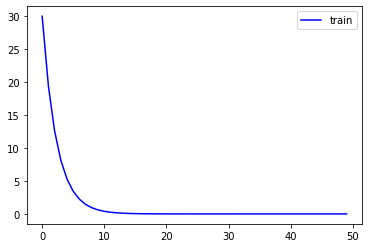

model weight: Parameter containing:
tensor([[ 2.0000, -3.4001]], device='cuda:0', requires_grad=True)
model bias: Parameter containing:
tensor([4.2004], device='cuda:0', requires_grad=True)


In [34]:
#Q1: Linear Regression

EPOCH_NUM = 50

transform = transforms.Compose(
    [transforms.ToTensor()])
train_dl, _ = create_dataloader('example', transform=None)


model = LinearRegression()
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

train_loss_list = []
best_train_loss = None

epoch = EPOCH_NUM
for i in range(epoch):
    train_loss, _ = one_epoch(model, train_dl, device, criterion, optimizer)
    train_loss_list.append(train_loss)

    if i==0 or best_train_loss >= train_loss:
            best_train_loss = train_loss

    if i%5 == 0:
        print('EPOCH:{:} Train: loss={:.3}'.format(i,train_loss))

print('Best train loss={:.3}'.format(best_train_loss))

fig, ax = plt.subplots()
ax.plot(train_loss_list, 'b', label='train')
ax.legend()
plt.show()

print("model weight:", model.linear.weight)
print("model bias:", model.linear.bias)


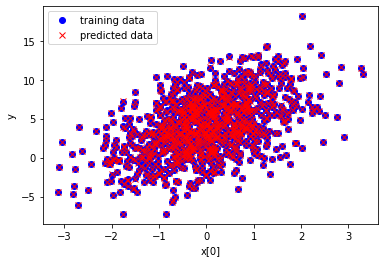

In [35]:

x_train = train_dl.dataset.tensors[0].detach().numpy().reshape(-1,2)
y_train = train_dl.dataset.tensors[1].detach().numpy().reshape(-1)

y_pred = []
for datas, targets in train_dl:
        datas, targets = datas.to(device), targets.to(device)
        
        with torch.no_grad():
            logits = model(datas)
            y_pred.append(logits.cpu().numpy().reshape(-1))
y_pred = np.array(y_pred).reshape(-1)

fig, ax = plt.subplots()
ax.plot(x_train[:,0], y_train, "bo", label="training data")
ax.plot(x_train[:,0], y_pred, "rx", label="predicted data")
ax.set_xlabel("x[0]")
ax.set_ylabel("y")
ax.legend()
plt.show()

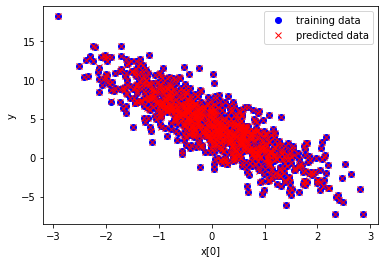

In [36]:
fig, ax = plt.subplots()
ax.plot(x_train[:,1], y_train, "bo", label="training data")
ax.plot(x_train[:,1], y_pred, "rx", label="predicted data")
ax.set_xlabel("x[0]")
ax.set_ylabel("y")
ax.legend()
plt.show()

/home/miki225/miki/myvenv/rinkovenv/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
EPOCH:0, Train: loss=1.98, acc=55.867% Test: loss=1.88, acc=62.520%
EPOCH:5, Train: loss=1.78, acc=71.793% Test: loss=1.75, acc=75.180%
EPOCH:10, Train: loss=1.71, acc=78.375% Test: loss=1.71, acc=77.750%
EPOCH:15, Train: loss=1.69, acc=79.237% Test: loss=1.7, acc=78.560%
EPOCH:20, Train: loss=1.69, acc=79.745% Test: loss=1.69, acc=79.130%
EPOCH:25, Train: loss=1.68, acc=80.105% Test: loss=1.68, acc=79.330%
EPOCH:30, Train: loss=1.68, acc=80.347% Test: loss=1.68, acc=79.530%
EPOCH:35, Train: loss=1.67, acc=80.548% Test: loss=1.68, acc=79.690%
EPOCH:40, Train: loss=1.67, acc=80.752% Test: loss=1.68, acc=79.830%
EPOCH:45, Train: loss=1.67, acc=80.927% Test: loss=1.67, acc=79.950%
EPOCH:50, Train: loss=1.67, acc=81.017% Test: loss=1.67, acc=80.090%
EPOCH:55, Train: loss=1.66, acc=8

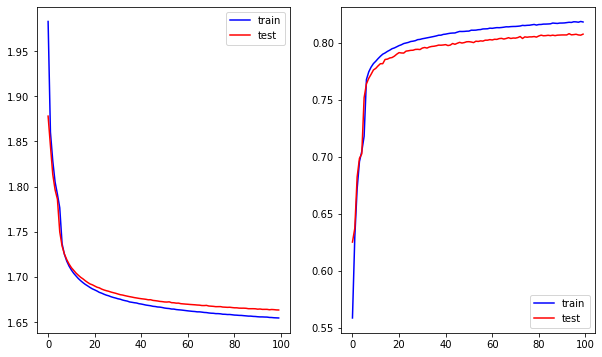

In [36]:
#Q2: Softmax Regression
EPOCH_NUM = 100

transform = transforms.Compose(
    [transforms.ToTensor()])

train_dl, test_dl = create_dataloader('MNIST', transform)

model = SingleModel()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list = train(model, train_dl, test_dl, EPOCH_NUM, device, criterion, optimizer)

fig= plt.figure(figsize=(10.0, 6.0))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(train_loss_list, 'b', label='train')
ax1.plot(test_loss_list, 'r', label='test')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(train_accuracy_list, 'b', label='train')
ax2.plot(test_accuracy_list, 'r', label='test')
ax2.legend()
plt.show()


/home/miki225/miki/myvenv/rinkovenv/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/home/miki225/miki/myvenv/rinkovenv/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



<AxesSubplot:>

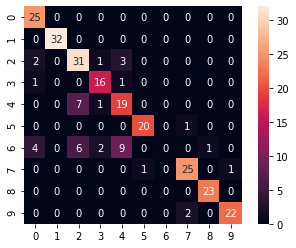

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = []
corrects = []

for datas, targets in tqdm_notebook(test_dl):
    datas, targets = datas.to(device), targets.to(device)

    with torch.no_grad():
        logits = model(datas)
    
    pred = torch.argmax(logits, dim=1)
    predictions.append(pred.cpu().numpy())
    corrects.append(targets.cpu().numpy())


predictions = predictions[0]
corrects = corrects[0]

cm = confusion_matrix(corrects, predictions)
sns.heatmap(cm, annot=True, square=True)


ipykernel_launcher:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
EPOCH:0, Train: loss=2.3, acc=26.908% Test: loss=2.29, acc=35.530%
EPOCH:5, Train: loss=2.09, acc=47.280% Test: loss=2.05, acc=52.890%
EPOCH:10, Train: loss=1.89, acc=62.458% Test: loss=1.89, acc=62.360%
EPOCH:15, Train: loss=1.86, acc=62.888% Test: loss=1.86, acc=62.860%
EPOCH:20, Train: loss=1.84, acc=63.172% Test: loss=1.84, acc=63.060%
EPOCH:25, Train: loss=1.83, acc=64.273% Test: loss=1.83, acc=64.160%
EPOCH:30, Train: loss=1.81, acc=67.832% Test: loss=1.81, acc=67.640%
EPOCH:35, Train: loss=1.8, acc=69.857% Test: loss=1.79, acc=69.790%
EPOCH:40, Train: loss=1.78, acc=70.832% Test: loss=1.78, acc=70.730%
EPOCH:45, Train: loss=1.77, acc=71.462% Test: loss=1.77, acc=71.280%
EPOCH:50, Train: loss=1.76, acc=71.882% Test: loss=1.76, acc=71.540%
EPOCH:55, Train: loss=1.76, acc=72.245% Test: loss=1.76, acc=71.740%
EPOCH:60, Train: loss=1.75, acc=

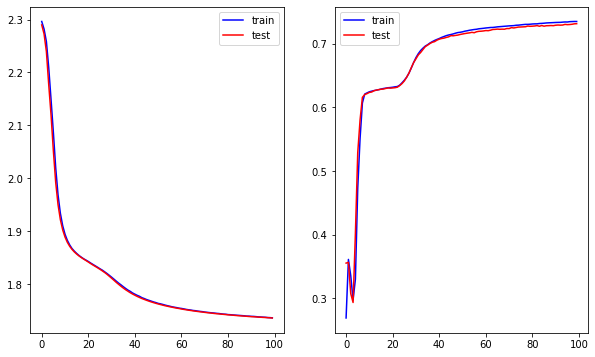

In [17]:
#Q3: Multilayer Perceptrons

EPOCH_NUM = 100

transform = transforms.Compose(
    [transforms.ToTensor()])

train_dl, test_dl = create_dataloader('MNIST', transform)

model = MultPerceptronModel()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list = train(model, train_dl, test_dl, EPOCH_NUM, device, criterion, optimizer)

fig= plt.figure(figsize=(10.0, 6.0))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(train_loss_list, 'b', label='train')
ax1.plot(test_loss_list, 'r', label='test')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(train_accuracy_list, 'b', label='train')
ax2.plot(test_accuracy_list, 'r', label='test')
ax2.legend()
plt.show()